In [1]:
from time import time

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import torch
import sklearn.datasets
import sklearn.preprocessing
import sklearn.model_selection
import numpy as np
import math
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST as FMNIST
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms
import tensorflow as tf
import random as r
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten, Activation, BatchNormalization
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import time
import sys
import math
import numpy as np
import random
import joblib
from tqdm import tqdm_notebook
import copy

import Config
import Dataloader as DL

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
datasets=[
    "KDD Cup 1999",                            #0
    "Microsoft Challenge BIG 2015"             #1
]
presets = {
    "KDD Cup 1999": {
        "NeuralHD": [300,2,3,.1],
        "OnlineHD": [300,1.0,.1,30,True],
        "MLP": [100,5,.001],
        "SVM": [10000]
    },
    "Microsoft Challenge BIG 2015": {
        "NeuralHD": [3000,6,10,.1],
        "OnlineHD": [3000,1.0,.1,30,True],
        "MLP": [100,30,.001],
        "SVM": [None]
    }
}
def normalized(x,y):
    xtrain, x_test, ytrain, y_test = None,None,None,None
    x, x_test, y, y_test = sklearn.model_selection.train_test_split(x, y, shuffle=True)
    scaler = sklearn.preprocessing.Normalizer().fit(x)
    x = scaler.transform(x)
    x_test = scaler.transform(x_test)

    # changes data to pytorch's tensors
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long()
    return x.numpy(), x_test.numpy(), y.numpy(), y_test.numpy(), scaler
def getuniquevalues(columnname,df):
    values={}
    i=0
    for entry in df[columnname]:
        if entry not in values:
            values[entry]=i
            i+=1
    return values
def get_dataset(name):
    if name==datasets[0]:
        path="../../Data/"
        attacks_types = {
            'normal': 'normal','back': 'dos','buffer_overflow': 'u2r','ftp_write': 'r2l','guess_passwd': 'r2l',
        'imap': 'r2l','ipsweep': 'probe','land': 'dos','loadmodule': 'u2r','multihop': 'r2l','neptune': 'dos',
        'nmap': 'probe','perl': 'u2r','phf': 'r2l','pod': 'dos','portsweep': 'probe','rootkit': 'u2r','satan': 'probe',
        'smurf': 'dos','spy': 'r2l','teardrop': 'dos','warezclient': 'r2l','warezmaster': 'r2l',
        }
        cols ="""duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,
        urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,
        num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,
        count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,
        diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,
        dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,
        dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate"""
        
        columns =[]
        for c in cols.split(','):
            if(c.strip()):
                columns.append(c.strip())
        print(len(columns))
        columns.append('target')
        print(len(columns))

        attack_categories=["dos","u2r","r2l",'probe','normal']
        df = pd.read_csv(path+"kddcup.data_10_percent.gz", names = columns)
        df['Attack Type'] = df.target.apply(lambda r:attacks_types[r[:-1]])
        del df['target']
        df.head()
        num_cols = df._get_numeric_data().columns
        
        cate_cols = list(set(df.columns)-set(num_cols))
        cate_cols.remove('Attack Type')
        for col in cate_cols:
            df[col]=df[col].map(getuniquevalues(col,df))
        data=df.to_numpy()
        Y=df['Attack Type'].map(getuniquevalues('Attack Type',df))
        Y=Y.to_numpy()
        X=data[:,:-1]
        print(Y.shape)
        print(X.shape)
        print(getuniquevalues('Attack Type',df))
        xtrain, x_test, ytrain, y_test,scaler= normalized(X,Y)
    if name==datasets[1]:
        path="../../Data/malware-classification/"
        map={}
        mapping=pd.read_csv(path + "trainLabels.csv")
        Y=mapping["Class"].to_numpy()
        for i in range(0,len(Y)):
            map[mapping["Id"][i]]=mapping["Class"][i]-1
        byte_features=pd.read_csv(path+"result.csv")
        byte_features['ID']  = byte_features['ID'].str.split('.').str[0]
        byte_features.head(3)
        byte_features['ID']=byte_features['ID'].map(map)
        data=byte_features.to_numpy()
        X=data[:,1:]
        Y=data[:,0]
        xtrain, x_test, ytrain, y_test,scaler= normalized(X,Y)
    return xtrain,x_test,ytrain,y_test

In [3]:
datasetname="Microsoft Challenge BIG 2015"

xtrain,x_test,ytrain,y_test=get_dataset(datasetname)

In [4]:
def get_class_accuracy_breakdown(model,x_test,y_test, output=False):
    acc=[]
    points=[]
    try:
        for i in range (0,len(np.unique(y_test))):
            yhat= model.predict(x_test[y_test==i])
            if len(yhat.shape)==2:
                yhat=np.array([row.argmax() for row in yhat])
            acc.append((yhat==i).mean())
            points.append(len(yhat))
    except:
        for i in range (0,len(np.unique(y_test))):
            yhat= model.predict(torch.from_numpy(x_test[y_test==i]))
            acc.append((yhat==i).float().mean())
            points.append(len(yhat))
    # print(yhat[:30])
    totacc=sum([acc[i]*points[i] for i in range(0,len(acc))])/sum(points)
    if output:
        plt.bar(range(0,len(acc)),acc,color=np.random.rand(3,))
        plt.title("Accuracy Total: " + str(totacc))
        plt.show()
    return totacc

In [5]:
xtraintorch=torch.from_numpy(xtrain)
ytraintorch=torch.from_numpy(ytrain)
x_testtorch=torch.from_numpy(x_test)
y_testtorch=torch.from_numpy(y_test)

In [7]:
import onlinehd as Onlinehd
import warnings

In [12]:
for i in range(0,10):
    model = Onlinehd.OnlineHD(len(np.unique(y_test)), x_test.shape[1], dim=1000)
    model.fit(torch.from_numpy(xtrain),torch.from_numpy(ytrain), bootstrap=4, lr=.037, epochs=50, one_pass_fit=False)
    print(get_class_accuracy_breakdown(model,x_test,y_test))

tensor(0.8885)
tensor(0.8848)
tensor(0.8888)
tensor(0.8822)
tensor(0.8852)
tensor(0.8771)
tensor(0.8760)
tensor(0.8896)
tensor(0.8826)
tensor(0.8866)


In [16]:
import onlinehd as Onlinehd
import warnings
for i in range(0,10):
    model = Onlinehd.OnlineHD(len(np.unique(y_test)), x_test.shape[1], dim=1000)
    model.fit(torch.from_numpy(xtrain),torch.from_numpy(ytrain), bootstrap=16, lr=.037, epochs=50, one_pass_fit=False)
    print(get_class_accuracy_breakdown(model,x_test,y_test))

tensor(0.9179)
tensor(0.9172)
tensor(0.9323)
tensor(0.9245)
tensor(0.9297)
tensor(0.9223)
tensor(0.9242)
tensor(0.9286)
tensor(0.9326)
tensor(0.9220)


In [19]:
import onlinehd as Onlinehd
import warnings
for i in range(0,10):
    model = Onlinehd.OnlineHD(len(np.unique(y_test)), x_test.shape[1], dim=1000)
    time.time()
    model.fit(torch.from_numpy(xtrain),torch.from_numpy(ytrain), bootstrap=64, lr=.037, epochs=50, one_pass_fit=False)
    print(get_class_accuracy_breakdown(model,x_test,y_test))

KeyboardInterrupt: 

In [26]:
import onlinehd as Onlinehd
import warnings
for i in range(0,10):
    model = Onlinehd.OnlineHD(len(np.unique(y_test)), x_test.shape[1], dim=1000)
    model.fit(torch.from_numpy(xtrain),torch.from_numpy(ytrain), encoded = False, lr = 3e-3, epochs = 128, bootstrap = 64, one_pass_fit = False)
    print(get_class_accuracy_breakdown(model,x_test,y_test))

tensor(0.9525)
tensor(0.9514)
tensor(0.9496)
tensor(0.9558)
tensor(0.9485)
tensor(0.9463)
tensor(0.9382)
tensor(0.9452)
tensor(0.9529)
tensor(0.9555)


In [32]:
for i in range(0,10):
    model = Onlinehd.OnlineHD(len(np.unique(y_test)), x_test.shape[1], dim=1000)
    for j in range(0,128):
        model.fit(torch.from_numpy(xtrain),torch.from_numpy(ytrain), encoded = False, lr = 3e-3, epochs = 1, bootstrap = 64, one_pass_fit = False)
    print(get_class_accuracy_breakdown(model,x_test,y_test))

tensor(0.9529)
tensor(0.9580)
tensor(0.9566)
tensor(0.9573)
tensor(0.9533)
tensor(0.9330)
tensor(0.9488)
tensor(0.9540)
tensor(0.9544)
tensor(0.9555)


In [36]:
for j in range(0,128):
    model.fit(torch.from_numpy(xtrain),torch.from_numpy(ytrain), encoded = False, lr = 3e-3, epochs = 1, bootstrap = 64, one_pass_fit = False)
    print(get_class_accuracy_breakdown(model,x_test,y_test))

tensor(0.8980)
tensor(0.9448)
tensor(0.9304)
tensor(0.9315)
tensor(0.9293)
tensor(0.8984)
tensor(0.9400)
tensor(0.9507)
tensor(0.9507)
tensor(0.9404)
tensor(0.9385)
tensor(0.9271)
tensor(0.9433)
tensor(0.9264)
tensor(0.9474)
tensor(0.9496)
tensor(0.9496)
tensor(0.9422)
tensor(0.9444)
tensor(0.9481)
tensor(0.9518)
tensor(0.9378)
tensor(0.9533)
tensor(0.7096)
tensor(0.9437)
tensor(0.9448)
tensor(0.9356)
tensor(0.9176)
tensor(0.9304)
tensor(0.9444)
tensor(0.9474)
tensor(0.9485)
tensor(0.9496)
tensor(0.9301)
tensor(0.9503)
tensor(0.9606)
tensor(0.9378)
tensor(0.9533)
tensor(0.9374)
tensor(0.9128)
tensor(0.9448)
tensor(0.9544)
tensor(0.9533)
tensor(0.9385)
tensor(0.9223)
tensor(0.9488)
tensor(0.9242)
tensor(0.9573)
tensor(0.9485)
tensor(0.9463)
tensor(0.9577)
tensor(0.9216)
tensor(0.9529)
tensor(0.9510)
tensor(0.9448)
tensor(0.9510)
tensor(0.9547)
tensor(0.9448)
tensor(0.9297)
tensor(0.9547)
tensor(0.9503)
tensor(0.9474)
tensor(0.9510)
tensor(0.9522)
tensor(0.9393)
tensor(0.9562)
tensor(0.9

In [35]:
accs=[]
vals=[]
model = Onlinehd.OnlineHD(len(np.unique(y_test)), x_test.shape[1], dim=1000)
for i in range(0,10):
    maxval=0
    for j in range(0,10):
        temp=copy.deepcopy(model)
        x_outr,y_outr=outersplit(xtraintorch,ytraintorch,j%10+1,10)#j%10+
        temp.fit(torch.from_numpy(xtrain),torch.from_numpy(ytrain), encoded = False, lr = 3e-3, epochs = 1, bootstrap = 64, one_pass_fit = False)
        x_val,y_val = innersplit(xtraintorch,ytraintorch,j%10+1,10)
        valaccuracy=get_class_accuracy_breakdown(temp,x_val.numpy(),y_val.numpy())
        if valaccuracy>maxval:
            model=copy.deepcopy(temp)
            maxval=valaccuracy
        accs.append(float(get_class_accuracy_breakdown(model,x_test,y_test).unsqueeze(0)))
print(get_class_accuracy_breakdown(model,x_test,y_test))

tensor(0.9459)


In [9]:
def outersplit(xtraintorch,ytraintorch,num,div):
    start=int((num-1)*xtraintorch.size(0)/div)
    end=int(num*xtraintorch.size(0)/div)
    first=xtraintorch[:start]
    last=xtraintorch[end:]
    xtrspl=torch.concat((first,last),dim=0)
    first=ytraintorch[:start]
    last=ytraintorch[end:]
    ytrspl=torch.concat((first,last),dim=0)
    return xtrspl,ytrspl
def innersplit(xtraintorch,ytraintorch,num,div):
    start=int((num-1)*xtraintorch.size(0)/div)
    end=int(num*xtraintorch.size(0)/div)
    xtrspl=xtraintorch[start:end]
    ytrspl=ytraintorch[start:end]
    return xtrspl,ytrspl

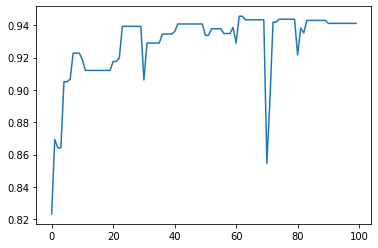

In [34]:
plt.plot(range(0,100),accs)